# **Import Libraries**

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import glob
import warnings

In [ ]:
warnings.filterwarnings('ignore')

# **Connecting to Google Drive**

In [ ]:
# Mount Google Drive to access dataset
drive.mount('/content/drive')

Mounted at /content/drive


# **Set Constants and Dataset Path**

In [ ]:
# ======================== Load Data ========================
# Define the dataset directory (adjust this path based on your Kaggle file system)
dataset_dir = '/content/drive/MyDrive/Datasets/trashnet'  # Update this based on dataset structure

# **Define Data Loading Function**

In [ ]:
# Load file paths and their labels, shuffle the list to randomize data access
files = glob.glob(dataset_dir + "/*/*")
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns=["Image", "Label"])

In [ ]:
# Visualize first few files
print("Dataset Sample:")
print(dataframe.head())

Dataset Sample:
                                               Image  Label
0  /content/drive/MyDrive/Datasets/trashnet/trash...  trash
1  /content/drive/MyDrive/Datasets/trashnet/metal...  metal
2  /content/drive/MyDrive/Datasets/trashnet/paper...  paper
3  /content/drive/MyDrive/Datasets/trashnet/trash...  trash
4  /content/drive/MyDrive/Datasets/trashnet/glass...  glass


In [ ]:
# ======================== Dataset Preparation ========================
# Set parameters for image processing
target_size = (224, 224)             # Image size that the model requires
batch_size = 64                      # Number of images used in each training step
validation_split = 0.2               # Portion of data used for validation

In [ ]:
# Create training and validation datasets
train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                         # Ensures reproducible results
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                        # Different seed for validation to randomize differently
    image_size=target_size,
    batch_size=batch_size,
)

# Class names
class_names = train.class_names
print("Class Names:", class_names)

Found 6283 files belonging to 6 classes.
Using 5027 files for training.
Found 6283 files belonging to 6 classes.
Using 1256 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# **Some Sample Data**

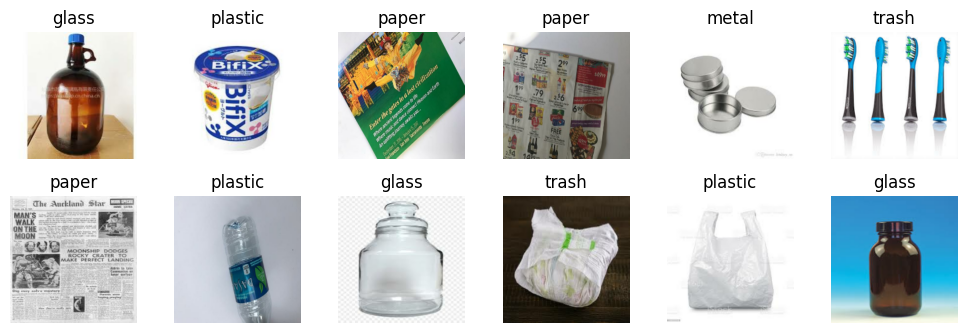

In [ ]:
# ======================== Display Sample Images ========================
# Visualizing some of the training images with their labels
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(12):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.savefig('sample_images.png', dpi=300)  # Save in high definition

# **Build the Model**

In [ ]:
# ======================== Build the Eco_Fri_NN Model ========================
# Building a model using EfficientNetV2B1 base
base_model = tf.keras.applications.EfficientNetV2B1(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze this base model to avoid affecting pretrained weights

# Constructing the enhanced model

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])
# building the model
eco_fri_nn = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# **Train the Model**

In [ ]:
# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_eco_fri_nn_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
eco_fri_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_eco_fri_nn = eco_fri_nn.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - accuracy: 0.5864 - loss: 3.2663 - val_accuracy: 0.9339 - val_loss: 2.3596
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.8978 - loss: 2.3930 - val_accuracy: 0.9666 - val_loss: 2.1213
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9221 - loss: 2.1797 - val_accuracy: 0.9769 - val_loss: 1.9547
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9341 - loss: 2.0235 - val_accuracy: 0.9761 - val_loss: 1.8162
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.9448 - loss: 1.8689 - val_accuracy: 0.9817 - val_loss: 1.6797
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.9552 - loss: 1.7137 - val_accuracy: 0.9817 - val_loss: 1.5524
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.9626 - loss: 1.5781 - val_accuracy: 0.9841 - val_loss: 1.4295
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9653 - loss: 1.4604 - val_accuracy

# **Fine tuning the Model**

In [ ]:
# Load base model
base_model = tf.keras.applications.EfficientNetV2B1(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune top layers

# Freeze all layers except top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

eco_fri_nn = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_eco_fri_nn_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
eco_fri_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_eco_fri_nn = eco_fri_nn.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 79s 518ms/step - accuracy: 0.5754 - loss: 3.3222 - val_accuracy: 0.9506 - val_loss: 2.3253
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.9097 - loss: 2.3521 - val_accuracy: 0.9745 - val_loss: 2.0791
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9451 - loss: 2.1018 - val_accuracy: 0.9825 - val_loss: 1.8978
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.9582 - loss: 1.9263 - val_accuracy: 0.9833 - val_loss: 1.7363
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9680 - loss: 1.7465 - val_accuracy: 0.9896 - val_loss: 1.5758
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9756 - loss: 1.5691 - val_accuracy: 0.9849 - val_loss: 1.4280
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9819 - loss: 1.4205 - val_accuracy: 0.9904 - val_loss: 1.2833
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9869 - loss: 1.2629 - val_accu

# **Model Summary**

In [ ]:
# Model Architecture
eco_fri_nn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b1 (Functional)  │ (None, 7, 7, 1280)     │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,191,688 (57.95 MB)

 Trainable params: 3,139,430 (11.98 MB)

 Non-trainable params: 5,773,396 (22.02 MB)

 Optimizer params: 6,278,862 (23.95 MB)

# **Saving Training History**

In [ ]:
# Save Training History
hist_eco_fri_nn_df = pd.DataFrame(hist_eco_fri_nn.history)
print("Training History:")
print(hist_eco_fri_nn_df)

Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.742590  2.860216      0.950637  2.325295
1   0.914661  2.296001      0.974522  2.079132
2   0.948677  2.061218      0.982484  1.897780
3   0.959021  1.888114      0.983280  1.736320
4   0.969167  1.708824      0.989650  1.575759
5   0.975731  1.539324      0.984873  1.428018
6   0.979312  1.389115      0.990446  1.283335
7   0.983688  1.240564      0.989650  1.153644
8   0.982097  1.120559      0.992834  1.030463
9   0.981898  1.005058      0.988854  0.938555
10  0.979511  0.910750      0.988057  0.842649
11  0.983489  0.816159      0.990446  0.743740
12  0.985478  0.724707      0.988854  0.677513
13  0.987070  0.646904      0.990446  0.594525
14  0.987269  0.570009      0.988854  0.538804
15  0.982892  0.531336      0.988854  0.490400
16  0.985677  0.474043      0.987261  0.445712
17  0.988263  0.418966      0.988854  0.400958
18  0.988064  0.382970      0.986465  0.375543
19  0.983290  0.365890      0.987261  0.35

# **Model Evaluation**

In [ ]:
# ======================== Evaluate Proposed Model on Validation Data ========================
# Prepare validation data for evaluation
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

# Get predictions from the model
predictions = eco_fri_nn.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

# Create Results DataFrame to compare true labels with predictions
results_df = pd.DataFrame()
results_df['Actual'] = y_val
results_df['Prediction'] = y_pred
print("Predictions vs Actual Labels:")
print(results_df)

40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 240ms/step
Predictions vs Actual Labels:
      Actual  Prediction
0          2           2
1          4           4
2          3           3
3          2           2
4          0           0
...      ...         ...
1251       5           5
1252       0           0
1253       5           5
1254       1           1
1255       1           1

[1256 rows x 2 columns]


# **Performance Curves**

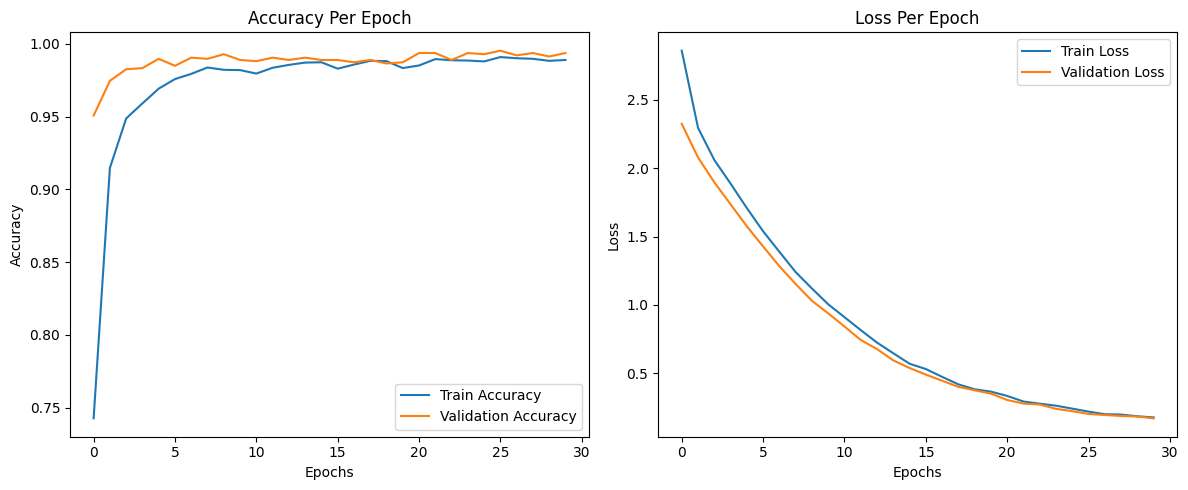

In [ ]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_eco_fri_nn_df['accuracy'], label='Train Accuracy')
plt.plot(hist_eco_fri_nn_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Per Epoch')

plt.subplot(1, 2, 2)
plt.plot(hist_eco_fri_nn_df['loss'], label='Train Loss')
plt.plot(hist_eco_fri_nn_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Per Epoch')

plt.tight_layout()
plt.savefig('accuracy_loss_per_epoch.png', dpi=300)  # Save in high definition

# **ROC Curve**

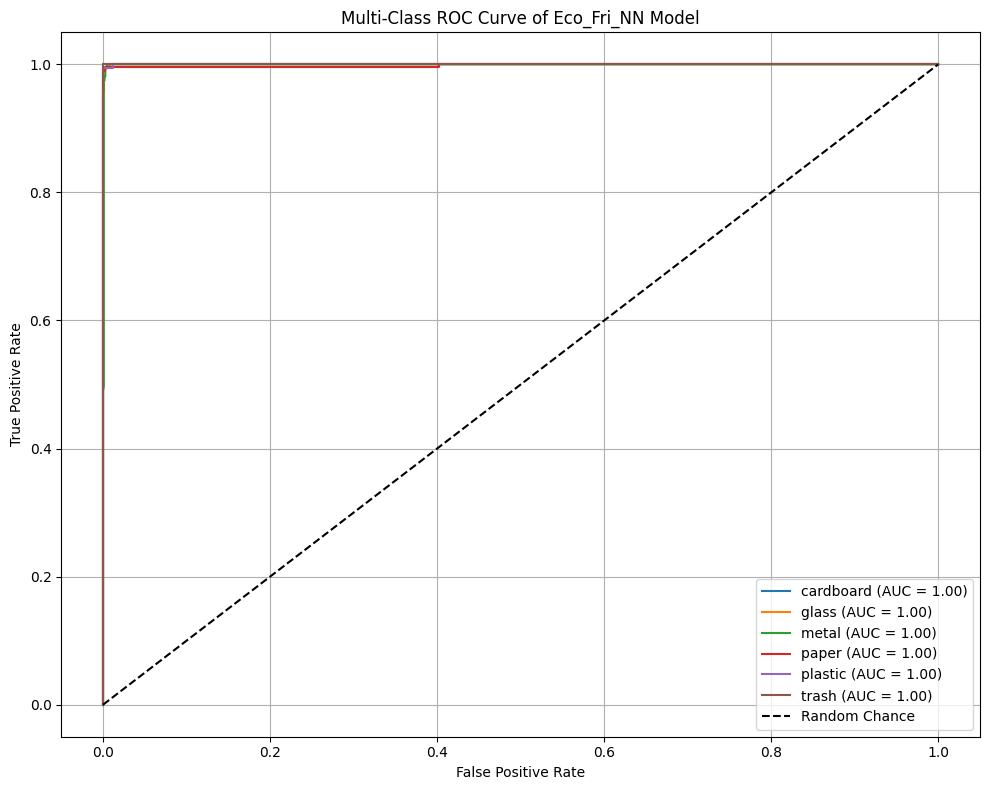

In [ ]:
# Binarize the true labels for multi-class ROC
y_val_bin = label_binarize(y_val, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_pred_probs = predictions  # already contains softmax outputs for each class

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    auc = roc_auc_score(y_val_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title('Multi-Class ROC Curve of Eco_Fri_NN Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('multi_class_roc_curve.png', dpi=300)
plt.show()

# **Confusion Matrix**

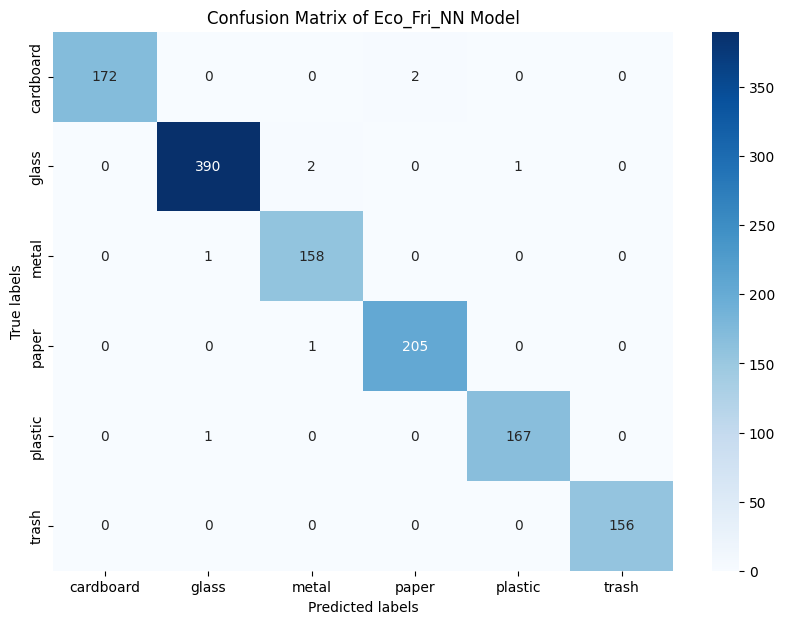

In [ ]:
# ======================== Confusion Matrix ========================
# Create confusion matrix to assess model predictions
CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of Eco_Fri_NN Model')
plt.savefig('confusion_matrix.png', dpi=300)  # Save in high definition

# **Performance Matrix**

In [ ]:
# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

Accuracy: 99.36%
Precision: 99.37%
Recall: 99.36%
F1 Score: 99.36%
Mean Absolute Error: 0.0127
Root Mean Square Error (RMSE): 0.1785

Classification Report:

              precision    recall  f1-score   support

   cardboard       1.00      0.99      0.99       174
       glass       0.99      0.99      0.99       393
       metal       0.98      0.99      0.99       159
       paper       0.99      1.00      0.99       206
     plastic       0.99      0.99      0.99       168
       trash       1.00      1.00      1.00       156

    accuracy                           0.99      1256
   macro avg       0.99      0.99      0.99      1256
weighted avg       0.99      0.99      0.99      1256



# **Output**

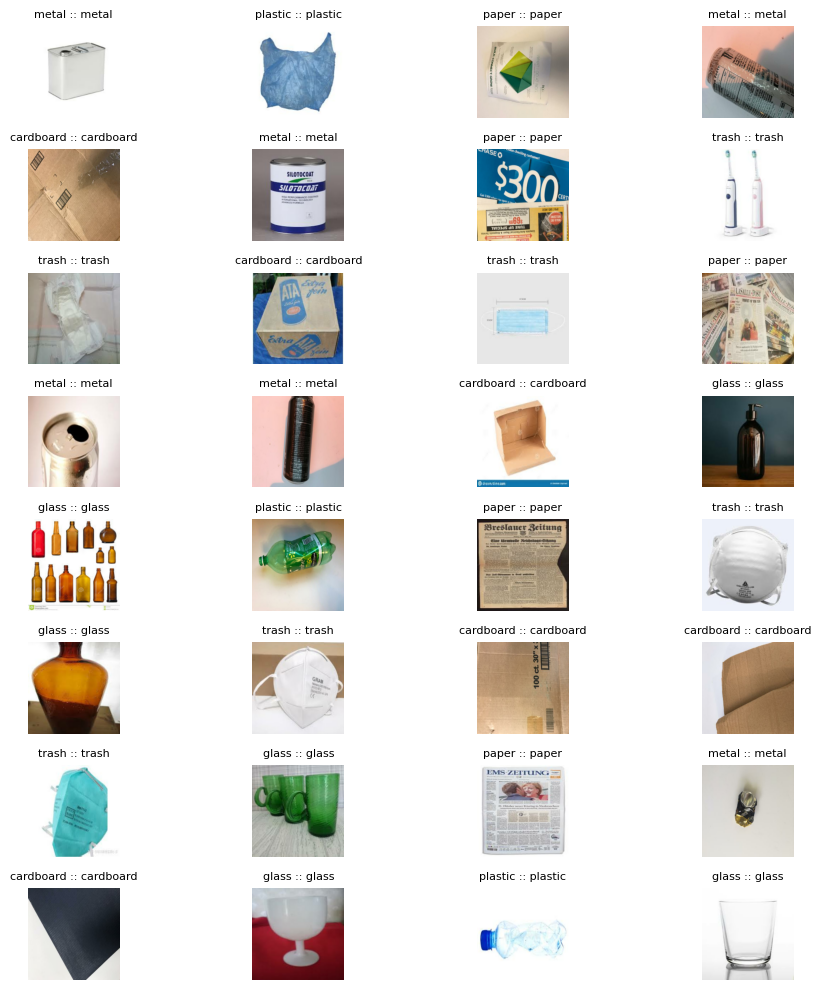

In [ ]:
# ======================== Show Images with Predictions ========================
# Visualizing predictions against actual labels
plt.figure(figsize=(10, 10))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}', fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.savefig('predictions_vs_actual_images.png', dpi=300)  # Save in high definition

# **Model Saving**

In [ ]:
# ======================== Save the Proposed Model ========================
# Save the trained model
eco_fri_nn.save('eco_fri_nn_model.keras')
print("Model Saved Successfully.")

Model Saved Successfully.


# **Adding XAI**

Using layer 'top_conv' for Grad-CAM.


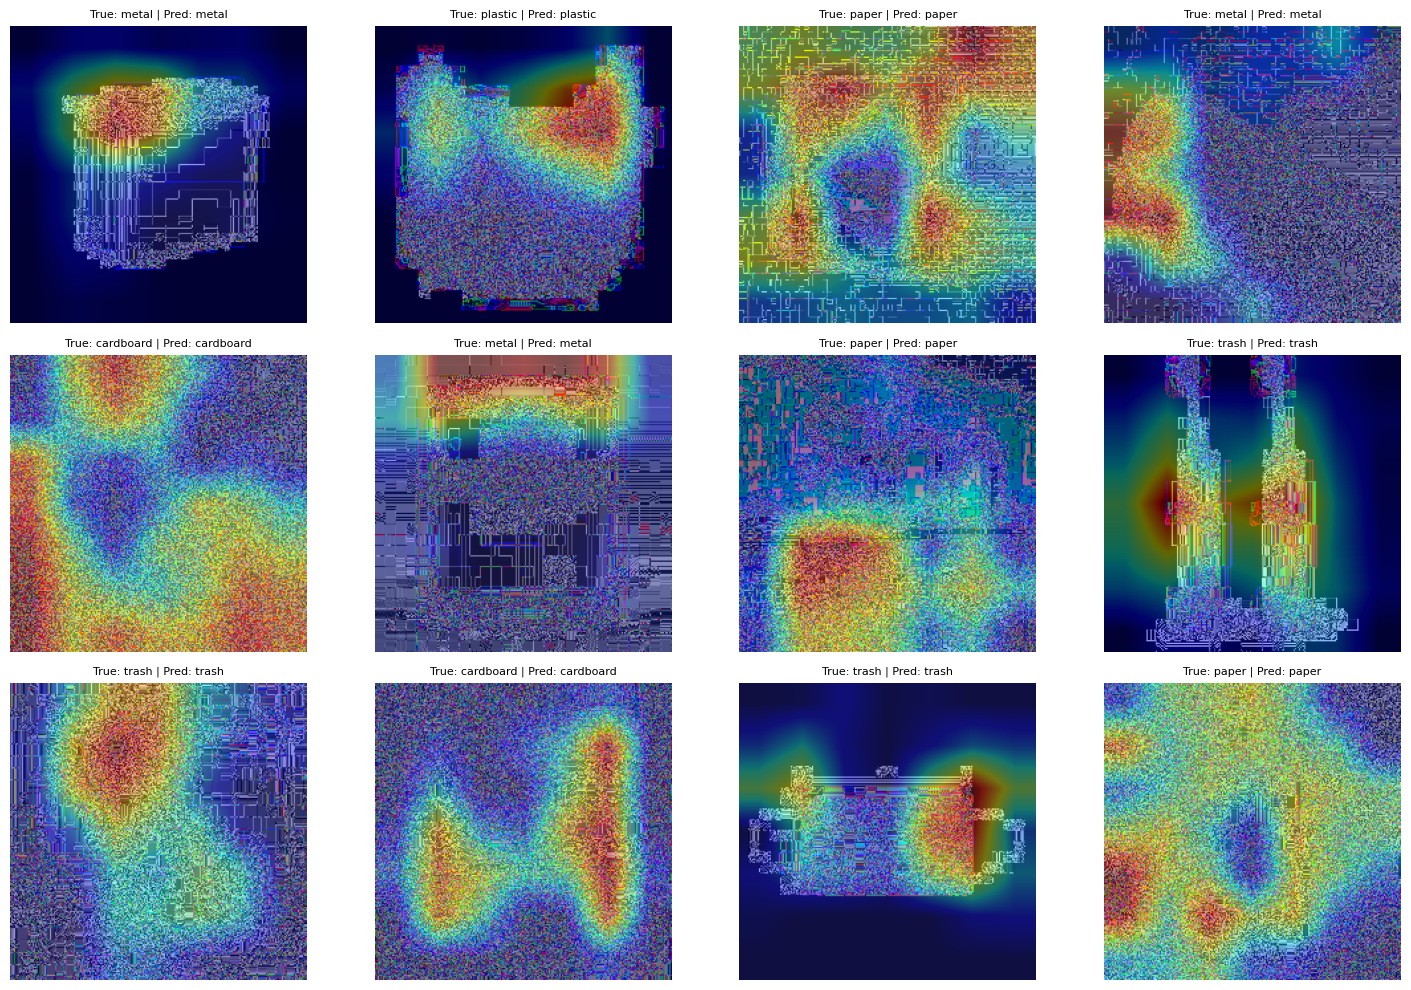

In [ ]:
# ======================== Grad-CAM for Explainability ========================
import tensorflow.keras.backend as K
import cv2
import matplotlib.cm as cm

# Step 1: Extract base_model (EfficientNetV2B1) from your Sequential model
base_model = eco_fri_nn.layers[0]

# Step 2: Identify the last Conv2D layer in EfficientNetV2B1
last_conv_layer_name = None
for layer in reversed(base_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    raise ValueError("No Conv2D layer found in EfficientNetV2B1.")

print(f"Using layer '{last_conv_layer_name}' for Grad-CAM.")

# Step 3: Grad-CAM utility functions

# Preprocess single image
def get_img_array(img):
    img = tf.image.resize(img, target_size)
    img = tf.expand_dims(img, axis=0)
    return img

# Generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, base_model, classifier_model, last_conv_layer_name, pred_index=None):
    # Get the output of the last conv layer
    grad_model = tf.keras.models.Model(
        [base_model.input],
        [base_model.get_layer(last_conv_layer_name).output, base_model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, base_output = grad_model(img_array)
        x = base_output
        # Forward pass through the rest of the model (excluding base_model)
        for layer in classifier_model.layers[1:]:  # Skip the base_model at index 0
            x = layer(x)
        preds = x

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

# Overlay heatmap on image
def show_gradcam(img, heatmap, alpha=0.4):
    # If img is a NumPy array, no need for .numpy()
    if isinstance(img, tf.Tensor):
        img = img.numpy()
    img = (img * 255).astype(np.uint8)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    jet = cm.get_cmap("jet")
    jet_colors = jet(heatmap)
    jet_heatmap = (jet_colors[:, :, :3] * 255).astype(np.uint8)

    # Ensure image is RGB
    if img.shape[-1] == 1:  # grayscale to RGB
        img = np.repeat(img, 3, axis=-1)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, jet_heatmap, alpha, 0)
    return superimposed_img


# ======================== Generate Grad-CAM for First 12 Validation Images ========================
plt.figure(figsize=(15, 10))
for i in range(12):
    img = X_val[i]
    label = y_val[i]
    pred = y_pred[i]

    img_array = get_img_array(img)

    heatmap = make_gradcam_heatmap(
        img_array,
        base_model=base_model,
        classifier_model=eco_fri_nn,
        last_conv_layer_name=last_conv_layer_name
    )

    gradcam_img = show_gradcam(img, heatmap)

    plt.subplot(3, 4, i + 1)
    plt.imshow(gradcam_img)
    plt.title(f"True: {class_names[label]} | Pred: {class_names[pred]}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.savefig("gradcam_visualization.png", dpi=300)
plt.show()
